Created 9/10/24 to see if we could make a streamlined version of the TESS scheduling software.

Outline
- Imports, set up, and helper functions
- Define observing strategies
- Define parameter ranges for per, tc, etc
- Run on the main mission
- Run on the extended mission strategies
- Save outputs
- Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from astropy.time import Time
from more_itertools import consecutive_groups

from tess_stars2px import TESS_Spacecraft_Pointing_Data
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px


## Set Up

In [3]:
# Read csvs
df = pd.read_csv('./target_df_longform.csv')
tdf = pd.read_csv('./target_df_shortform.csv')
df = df.drop(columns=df.columns[0])
tdf = tdf.drop(columns=tdf.columns[0])

# also fix the sec columns to that it isn't a string for some reason
from ast import literal_eval    
tdf["sec"] = tdf["sec"].apply(lambda x: literal_eval(x))

# ingest positions catalog
cat = pd.read_csv('CTLv8 (current).csv')
cat.rename(columns={'Right_Ascension':'ra', 'Declination':'dec', "TESSmag":'Tmag', 'Ecliptic_Longitude':'ec_long', 'Ecliptic_Latitude':'ec_lat', 'TIC_ID':'TIC'}, inplace=True)
# cat[:5]


In [4]:
# extract scheduling info
scinfo = TESS_Spacecraft_Pointing_Data(1)

# Note: Midtimes really do seem to be the MIDDLE of the tess sector, so inclusive times for it will be +/- 13.5 days
# goes up to sector 96, which is the conclusion of Year 7 observing (mix of north/south + some ecliptic)
midtimes = TESS_Spacecraft_Pointing_Data.midtimes
sec_cadence = np.mean(midtimes[1:] - midtimes[:-1]) # average time between sector midtimes
midtimes_fake = np.arange(len(midtimes)) * sec_cadence + midtimes[0]

sectors_all = TESS_Spacecraft_Pointing_Data.sectors
missionStart = midtimes[0] - 13.5
missionStop = midtimes[-1] + 13.5


In [6]:
# Helper Functions
def max_consecutive_sequence(arr):
    return max([len(list(i)) for i in consecutive_groups(arr)])

def calc_transit_times_phase(period, tc_phase, dur=2, start_time=missionStart, stop_time=missionStop):
    """period - days
    tc_phase - the fractional phase that the transit occurs at
    duration - duration in hours
    """
    transit_times = np.arange(start_time + tc_phase*period, stop_time, period)
    return transit_times

def calc_transit_times_tc(period, tc, dur=2, start_time=missionStart, stop_time=missionStop):
    """period - days
    tc - one time that the transit occurs at (does not need to be the first)
    duration - duration in hours
    """
    # Calculate the first occurrence of the event time after the start time
    first_occurrence = start_time + ((tc - start_time) % period)
    transit_times = np.arange(first_occurrence, stop_time + 1, period)
    return transit_times



## Define Observing Strats

In [11]:
# Helper Functions
def extend_sectors(sectors, ext_strategy):
    """sectors - the sectors observed from 1-96
    ext_strategy - the sectors who's pointings will be repeated in the extended mission, in order of execution"""
    sec_set = set(sectors)
    full_strategy = np.hstack([np.arange(1,97), ext_strategy])
    full_secs = np.array([i+1 for i, val in enumerate(full_strategy) if val in sec_set])

    return full_secs

def get_new_midtimes(full_secs, midtimes_ext):
    return(midtimes_ext[np.array(full_secs)-1])

def add_new_observations(period, tc, new_midtimes, aliases, ruled_out):
    # check if a transit will appear in the new sectors
    true_obs = check_event_within_period(period, tc, new_midtimes)

    # check if the aliases would appear in the new sectors
    newly_ruled_out = np.array([True] * len(aliases))
    for ind in range(len(aliases)):
        if ~ruled_out[ind]:
            # see if that alias would result in a transit in the new sector
            pred_obs = check_event_within_period(aliases[ind], tc, new_midtimes)
            # print(pred_obs)

            # if any of the observations do not match the prediction, then that alias can be ruled out
            newly_ruled_out[ind] = (true_obs!=pred_obs)

    return np.array(newly_ruled_out).astype(bool)
   

In [12]:
# Define Strategies
# Assume that the extended mission will reuse pointings from previous sectors

# Default strategy, go south -> north
def_strat = sectors_all[:26]

# Flipped strategy, go north -> south
flip_strat = np.hstack([sectors_all[13:26], sectors_all[:13]])

(0.0, 120.0)

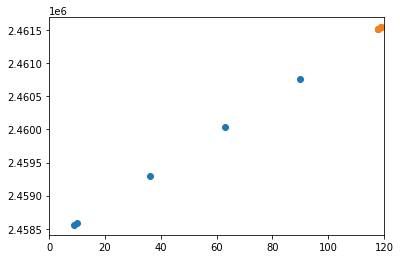

In [14]:
# example usage
# strat = def_strat
strat = flip_strat

# midtimes of just the extended mission
strat_midtimes = midtimes[-1] + sec_cadence * (1 + np.arange(len(strat)))

# "real" sector numbers and midtimes for the full mission (base+extended)
sectors_ext = np.arange(1, len(sectors_all)+len(strat)+1)
midtimes_ext = np.hstack([midtimes, strat_midtimes])

# extended mission start and stop
extStart = midtimes_ext[0] - sec_cadence
extStop = midtimes_ext[-1] + sec_cadence

# for a specific star
s = np.asarray(tdf.loc[301, 'sec'])
full_secs = extend_sectors(s, strat)  # target sectors, strategy
full_midtimes = get_new_midtimes(full_secs, midtimes_ext)
new_secs = full_secs[full_secs>96]
new_midtimes = full_midtimes[full_midtimes>missionStop]
# new_midtimes

plt.scatter(full_secs, full_midtimes)
plt.scatter(new_secs, new_midtimes)
plt.xlim([0,120])

## Run Experiment

In [ ]:
# define your range of periods and tc_phases]
periods = np.arange(20,70,.8)
tc_phases = np.arange(0,1,.1)

rows_list = []


## Analyze Results

In [8]:
# calc_transit_times_phase(51.45, .1)

# let's make calc_transit_times able to take in arrays of periods and tcs

start_time = 0

periods = np.array([10,12,15])
# tc_phases = np.array([0,.1,.2])


np.arange(start_time + tc_phase*period, stop_time, period)


array([2458331.297778  , 2458382.747778  , 2458434.197778  ,
       2458485.647778  , 2458537.097778  , 2458588.547778  ,
       2458639.997778  , 2458691.447778  , 2458742.897778  ,
       2458794.347778  , 2458845.797778  , 2458897.247778  ,
       2458948.697778  , 2459000.147778  , 2459051.597778  ,
       2459103.047778  , 2459154.497778  , 2459205.947778  ,
       2459257.397778  , 2459308.847778  , 2459360.297778  ,
       2459411.747778  , 2459463.197778  , 2459514.647778  ,
       2459566.097778  , 2459617.547778  , 2459668.997778  ,
       2459720.44777801, 2459771.89777801, 2459823.34777801,
       2459874.79777801, 2459926.24777801, 2459977.69777801,
       2460029.14777801, 2460080.59777801, 2460132.04777801,
       2460183.49777801, 2460234.94777801, 2460286.39777801,
       2460337.84777801, 2460389.29777801, 2460440.74777801,
       2460492.19777801, 2460543.64777801, 2460595.09777801,
       2460646.54777801, 2460697.99777801, 2460749.44777801,
       2460800.89777801,